# Simple Simulation Analysis

In this notebook I will analyse the output of a simple simulation. First, I load the output data of the two stations.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

depot_data = pd.read_csv('../output/depot_output.csv', index_col=0)
service_data = pd.read_csv('../output/server_output.csv', index_col=0)

depot_data.head()

,service_stock,repair_stock
0,9,1
1,10,2
2,11,3
3,12,4
4,13,0


## Visualisation of stock over time

The stock levels of the repairable and servicable units are recorded over time. Let's check these.

In [2]:
# Combine datasets
depot_data.columns = 'depot_' + depot_data.columns
service_data.columns = "server_" + service_data.columns
all_data = pd.concat([depot_data, service_data], axis=1)

# Add time index
all_data['time'] = range(all_data.shape[0])

all_data.head()

,depot_service_stock,depot_repair_stock,server_service_stock,server_repair_stock,time
0,9,1,0,8,0
1,10,2,0,6,1
2,11,3,0,4,2
3,12,4,0,2,3
4,13,0,0,5,4


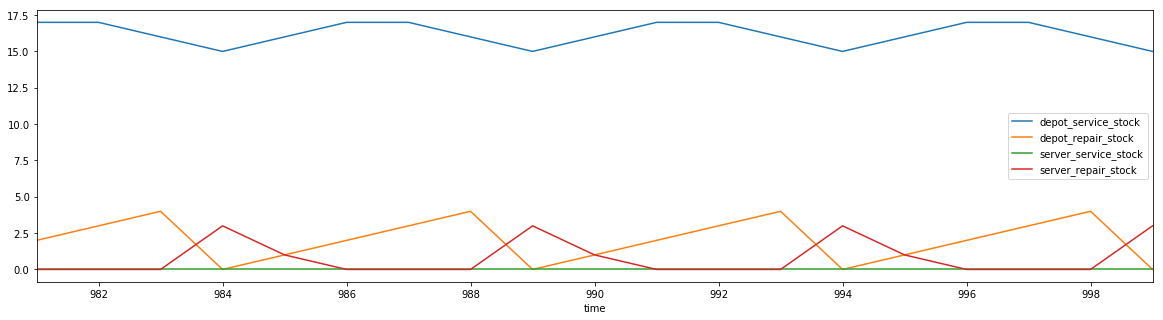

In [3]:
# Plot lines over time 
all_data[all_data.time > 980].plot(x='time', y=all_data.columns[0:4], figsize=[20, 5])

## Compute the average cycle cost

In this simple model, we assume that sending a batch from the server to the depot has a cost `c_d` and sending a batch of repairable units from the depot to the server costs `c_r`. In general we have that `c_r` > `c_d`, since the reverse flow is typically less efficient. Besides, set-up costs for orders, a holding costs of `h_d` per unit per unit of time for stock of servicable units at the depot has to be paid. In case of a shortage, a backlogging cost of `b_d` per unit per unit of time is incurred. For now, I do not assume any holding cost for the repairable units.

In [30]:
# Cost structure
c_d = 1
c_r = 3
h_d = 0.02
b_d = 0.4

# In this case, the cycle length can be easily eye-balled.
cycle_len = 4

# Take data for one cycle
cycle_data = all_data.query('984 <= time <= 988')

# Get all order events
depot_events = pd.read_csv('../output/depot_events.csv', index_col=0).query('984 <= time <= 988')
server_events = pd.read_csv('../output/server_events.csv', index_col=0).query('984 <= time <= 988')

# Count orders
n_order_depot = depot_events.shape[0]
n_order_server = server_events.shape[0]

# Inventory in numpy
depot_stock = cycle_data.depot_service_stock.to_numpy()

# Compute costs
total_order_costs = n_order_depot * c_r + n_order_server * c_d
total_var_costs = depot_stock.clip(min=0).sum() * h_d + np.sum(-depot_stock.clip(max=0)) * b_d

print(total_order_costs + total_var_costs)

9.620000000000001
